In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/stunting_wasting_dataset.csv")

In [3]:
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [4]:
df.describe()

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg)
count,100000.000000,100000.000000,100000.000000
mean,11.992580,73.132657,9.259256
std,7.199671,11.360846,3.300780
min,0.000000,42.600000,1.000000
25%,6.000000,65.500000,6.900000
50%,12.000000,74.200000,9.200000
75%,18.000000,81.400000,11.700000
max,24.000000,97.600000,17.200000


In [5]:
df1 = (
    df[["Berat Badan (kg)", "Jenis Kelamin", "Umur (bulan)", "Tinggi Badan (cm)"]]
    .rename(columns={
        "Jenis Kelamin": "jk",
        "Umur (bulan)": "umur_bln",
        "Tinggi Badan (cm)": "tinggi_cm",
        "Berat Badan (kg)": "berat_kg"
    })
    .copy()
)

## Laki-Laki: 1, Perempuan: 0
df1["jk"] = df1["jk"].map({"Laki-laki": 1, "Perempuan": 0})

df1.head()

,berat_kg,jk,umur_bln,tinggi_cm
0,13.3,1,19,91.6
1,8.5,1,20,77.7
2,10.3,1,10,79.0
3,8.3,0,2,50.3
4,10.9,0,5,56.4


In [6]:
corr_matrix = df1.corr()

print(corr_matrix)

           berat_kg        jk  umur_bln  tinggi_cm
berat_kg   1.000000  0.045797  0.665389   0.626005
jk         0.045797  1.000000  0.004046   0.073505
umur_bln   0.665389  0.004046  1.000000   0.875869
tinggi_cm  0.626005  0.073505  0.875869   1.000000


In [8]:
import seaborn as sns

In [9]:
import matplotlib.pyplot as plt

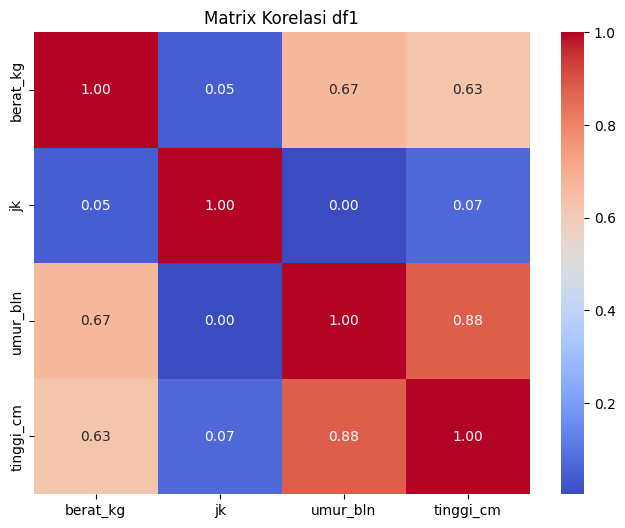

In [11]:
plt.figure(figsize = (8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt = ".2f")
plt.title("Matrix Korelasi df1")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

# Misalkan target (Y) adalah berat badan, variabel dependen
y = df1["berat_kg"]

# Fitur (X) adalah umur dan tinggi, variabel independen
X = df1[["umur_bln", "tinggi_cm"]]

# Bagi data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # random_state supaya hasil konsisten
)

# Cetak pembagian data
print("Jumlah data train :", len(X_train))
print("Jumlah data test  :", len(X_test))

# Cek apakah sudah ada data pada training set
X_train.head()


Jumlah data train : 80000
Jumlah data test  : 20000


,umur_bln,tinggi_cm
75220,2,51.9
48955,13,74.3
44966,17,86.7
13568,16,76.8
92727,20,78.5


In [15]:
X_train_const = sm.add_constant(X_train)
X_train_const.head()


,const,umur_bln,tinggi_cm
75220,1.0,2,51.9
48955,1.0,13,74.3
44966,1.0,17,86.7
13568,1.0,16,76.8
92727,1.0,20,78.5


In [16]:
import statsmodels.api as sm

# Buat model OLS (Ordinary Least Squares)
model = sm.OLS(y_train, X_train_const).fit()

print('-------------------')
print(model.params)
print('-------------------')

# Ambil nilai koefisien regresi
const = model.params['const']
x1_umur = model.params['umur_bln']
x2_tinggi = model.params['tinggi_cm']

# Print persamaan regresi
print(f"y = {const:.3f} + ({x1_umur:.3f})*x1 + ({x2_tinggi:.3f})*x2")

-------------------
const        2.545617
umur_bln     0.229719
tinggi_cm    0.054192
dtype: float64
-------------------
y = 2.546 + (0.230)*x1 + (0.054)*x2


In [17]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               berat_kg   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                 3.272e+04
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:16:33   Log-Likelihood:            -1.8505e+05
No. Observations:               80000   AIC:                         3.701e+05
Df Residuals:                   79997   BIC:                         3.701e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5456      0.091     28.039      0.0

In [19]:
import numpy as np

# Tambahkan konstanta ke data uji
X_test_const = sm.add_constant(X_test)

# Prediksi berat badan
y_pred_test = model.predict(X_test_const)

# Buat tabel hasil prediksi
hasil = pd.DataFrame({
    "Umur (bulan)": X_test["umur_bln"].to_numpy(),
    "Tinggi (cm)": X_test["tinggi_cm"].to_numpy(),
    "Berat Aktual (kg)": y_test.to_numpy(),
    "Berat Prediksi (kg)": y_pred_test
})

# 1) Selisih error (positif = overpredict)
hasil["Selisih error (kg)"] = hasil["Berat Prediksi (kg)"] - hasil["Berat Aktual (kg)"]

# 2) Akurasi per-baris (100 * (1 - |error|/aktual)), dibatasi 0–100
denom = hasil["Berat Aktual (kg)"].replace(0, np.nan)  # antisipasi pembagi nol
hasil["Akurasi (%)"] = (1 - (hasil["Selisih error (kg)"].abs() / denom)).clip(lower=0, upper=1) * 100

# Tampilkan hasil
hasil.head()

,Umur (bulan),Tinggi (cm),Berat Aktual (kg),Berat Prediksi (kg),Selisih error (kg),Akurasi (%)
75721,1,54.6,7.0,5.734226,-1.265774,81.917510
80184,8,66.0,12.2,7.960047,-4.239953,65.246290
19864,20,90.0,10.9,12.017284,1.117284,89.749692
76699,13,82.4,9.6,9.997392,0.397392,95.860500
92991,11,70.1,13.2,8.871391,-4.328609,67.207511
